In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import cv2
import pandas as pd
from tensorflow.keras.datasets import cifar10
from tqdm import tqdm
import datetime as dt
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [13]:
dt.datetime.now()

datetime.datetime(2020, 4, 11, 20, 4, 8, 585197)

In [14]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15796482256017052529
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2120446097841673969
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [15]:
def load_preprocess():
    ### Load In Data
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]


In [16]:
trainX, trainY, testX, testY = load_preprocess()

In [40]:
im_size =32
batch_size = 500
channels = 3
num_classes = 10
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0.00001
keep_prob = 0.5

In [41]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, GaussianNoise, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1

from tensorflow.keras.layers import BatchNormalization, Conv2D, GaussianNoise, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1

### Creating model architecture
he_init = tf.keras.initializers.VarianceScaling()
model = Sequential()
#model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(32, (3, 3),input_shape=input_shape,activation='relu',kernel_initializer =he_init))

model.add(GaussianNoise(0.01))
model.add(Conv2D(32, (3, 3),activation='relu',kernel_initializer =he_init))

#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(keep_prob))
model.add(
    Conv2D(64, (3, 3),activation='relu', kernel_initializer =he_init))
model.add(GaussianNoise(0.01))
model.add(
    Conv2D(128, (3, 3), activation='relu', kernel_initializer =he_init))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(keep_prob))
model.add(
    Conv2D(256, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                 kernel_initializer =he_init))

model.add(GaussianNoise(0.1))
model.add(
    Conv2D(256,(3, 3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                 kernel_initializer =he_init))
#model.add(BatchNormalization(input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(keep_prob))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                kernel_initializer =he_init))
model.add(Dropout(keep_prob))

model.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                kernel_initializer =he_init))
model.add(Dropout(keep_prob))
#model.add(GaussianNoise(0.01))
model.add(Dense(num_classes, activation='softmax', kernel_initializer =he_init))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
gaussian_noise_18 (GaussianN (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
dropout_30 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
gaussian_noise_19 (GaussianN (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 128)      

from tensorflow.keras.models import model_from_json
# load json and create model
#json_file = open('Models/model_fine_labels.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("Models/model_fine_labels.h5")
print("Loaded model from disk")

In [42]:
def scheduler(epoch):
    if epochs>10:
        return 0.001
    else: 
        return 0.001*tf.math.exp(0.1*(10-epoch))

In [ ]:
epochs = 500
batch_size = 1024
check_point_path = 'Models/checkpoints'
### Instantiate Callbacks
callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback2  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                  patience=5, min_lr=0.001)
callback3 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto',
    baseline=None,  restore_best_weights=True
)
callback4 = tf.keras.callbacks.ModelCheckpoint(
    check_point_path, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

###Compile and run Model
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
              loss = "categorical_crossentropy",  metrics= ['accuracy'])
history = model.fit(trainX,trainY, batch_size = batch_size, callbacks =[callback2, callback3],
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),
          )

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 [==============================] - 19s 379us/sample - loss: 2.2182 - accuracy: 0.1508 - val_loss: 2.2315 - val_accuracy: 0.1157
Epoch 2/500
50000/50000 [==============================] - 17s 350us/sample - loss: 2.0094 - accuracy: 0.2150 - val_loss: 2.1758 - val_accuracy: 0.1484
Epoch 3/500
50000/50000 [==============================] - 46s 916us/sample - loss: 1.8801 - accuracy: 0.2737 - val_loss: 1.9030 - val_accuracy: 0.3387
Epoch 4/500
50000/50000 [==============================] - 62s 1ms/sample - loss: 1.7959 - accuracy: 0.3349 - val_loss: 1.7636 - val_accuracy: 0.3806
Epoch 5/500
50000/50000 [==============================] - 62s 1ms/sample - loss: 1.6478 - accuracy: 0.4009 - val_loss: 1.6549 - val_accuracy: 0.4172
Epoch 6/500
50000/50000 [==============================] - 66s 1ms/sample - loss: 1.5450 - accuracy: 0.4452 - val_loss: 1.5117 - val_accuracy: 0.4718
Epoch 7/500
50000/50000 [===================

500


Text(0, 0.5, 'Validation Loss')

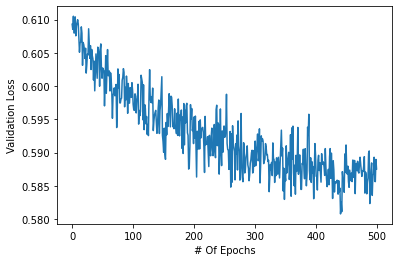

In [24]:
num = len(history.history['val_loss'])
type(history.history)
history.history.keys()
print(len(history.history['val_loss']))
plt.plot([i for i in range(len(history.history['val_loss']))],history.history['val_loss'])
plt.xlabel("# Of Epochs")
plt.ylabel("Validation Loss")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
500


Text(0, 0.5, 'Loss')

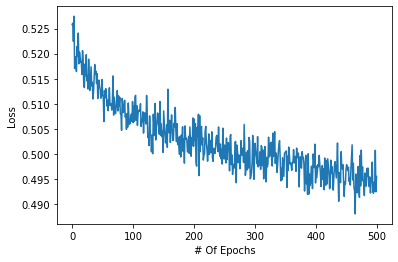

In [25]:
type(history.history)
print(history.history.keys())
print(len(history.history['val_loss']))
plt.plot([i for i in range(len(history.history['loss']))],history.history['loss'])
plt.xlabel("# Of Epochs")
plt.ylabel("Loss")

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, **kwargs)>

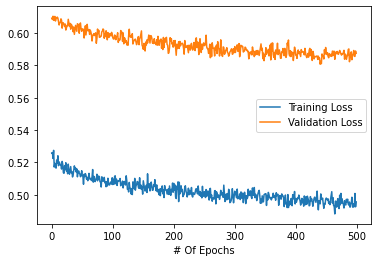

In [26]:
plt.plot([i for i in range(len(history.history['loss']))],history.history['loss'])
plt.plot([i for i in range(len(history.history['val_loss']))],history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel("# Of Epochs")
plt.ylabel

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')


scores = model.evaluate(testX, testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


# Serialize model to JSON
model_json = model.to_json()
with open("Models/model1.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model.save_weights("Models/model1.h5")
print("Saved model to disk")


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [49]:
pred = model.predict(xtest)

(10000, 100)

b'mountain'


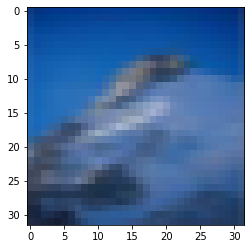

In [66]:
i = 418
plt.imshow(xtest[i].reshape((32,32,3)))
print(meta_data[b'fine_label_names'][np.argmax(ytest[i])])

b'seal'


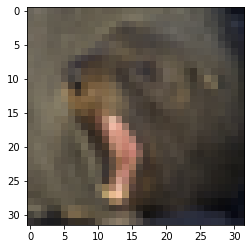

In [43]:
i = 42
plt.imshow(xtrain[i].reshape((32,32,3)))
print(meta_data[b'fine_label_names'][np.argmax(ytrain[i])])

In [ ]:

 
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

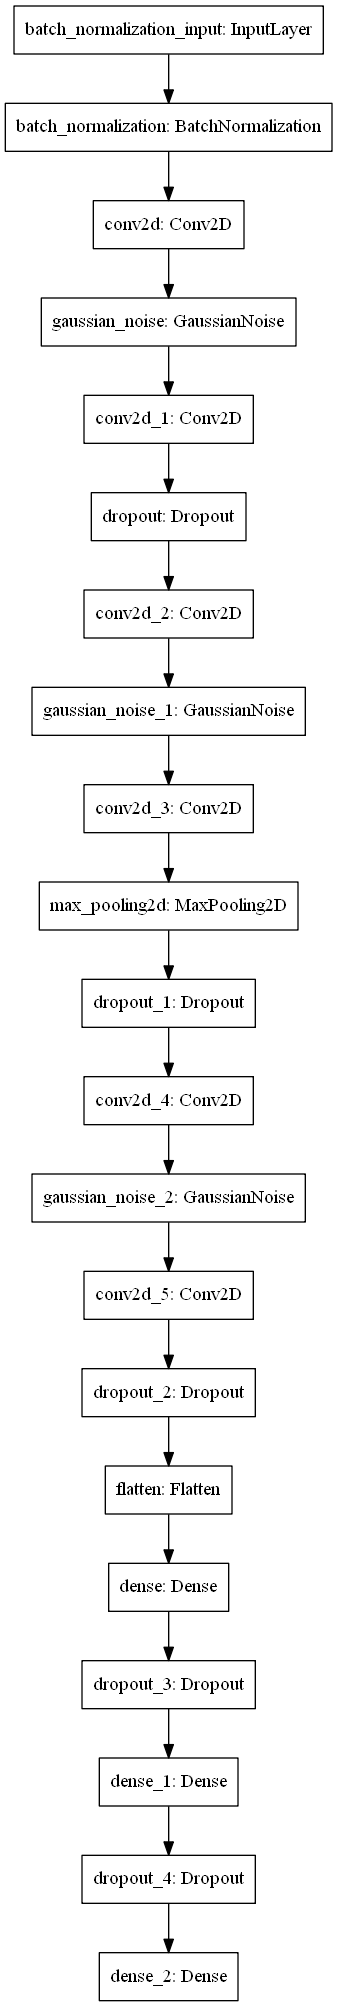

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7535922723941363830
]


In [31]:
tf.__version__


'2.1.0'

Num GPUs Available:  1


In [46]:
np.argmax(ytest, axis = 1)

array([63, 13, 69, ..., 32, 89, 41], dtype=int64)

In [53]:
print("-Confusion matrix")
confuse = tf.math.confusion_matrix(np.argmax(ytest,axis = 1), np.argmax(pred, axis = 1), num_classes = 100)


-Confusion matrix
tf.Tensor(
[[72  1  1 ...  1  0  0]
 [ 0 51  3 ...  0  1  1]
 [ 0  0 31 ...  1  6  0]
 ...
 [ 0  0  0 ... 43  0  0]
 [ 2  0  7 ...  0 28  0]
 [ 0  0  0 ...  0  2 35]], shape=(100, 100), dtype=int32)


In [55]:
import sys
import numpy
numpy.set_printoptions(threshold=np.inf)
print(confuse)

tf.Tensor(
[[72  1  1  1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  1  4  0  0 10  0  0  0  0  0  0  0  0  0  0  0  1  1  0
   0  0  0  0  0  0  1  0  0  0  0  7  0  0  0  0  0  0  0  0  3  0  0  0
   0  1  0  0]
 [ 0 51  3  0  1  0  0  1  0  0  0  0  0  1  2  0  0  0  1  1  0  0  0  1
   0  0  2  0  0  2  1  0  1  2  0  0  0  1  0  0  0  0  0  0  1  1  0  0
   1  1  1  0  0  2  0  0  0  1  0  0  0  0  3  0  0  1  0  2  0  0  2  0
   0  1  2  0  0  2  0  0  0  0  1  0  0  0  0  0  0  0  2  2  2  4  0  0
   2  0  1  1]
 [ 0  0 31  0  0  0  0  0  0  0  1  4  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  2  0  1  0  2  0  1  0  1  6  3  0  2  0  0  0  0  1  2  1  4  0
   0  0  2  0  0  0  0  0  0  0  0  0  0  2  0  0  2  1  1  0  0  0  0  0
   0  0  0  0  2  1  3  0  1  1  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  1  6  0]
 [ 0  1  0 26  1  0  0  2  0  0  0  0  0  1  0  1  0  0 